In [1]:
## Import dependencies
import numpy as np
import pickle
import pandas
import re
import glob
import datetime
import tensorflow as tf
import itertools
import math
import random
#!{sys.executable} -m pip install gensim
#from gensim.models.word2vec import Word2Vec
from collections import Counter
from sklearn.metrics import log_loss, auc, roc_curve
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import *
from keras.engine.topology import Input
from keras.models import Model, Sequential
from keras.utils import np_utils, to_categorical
from keras.optimizers import TFOptimizer, RMSprop

## Set random seeds for reproducibility
np.random.seed(123)
random.seed(123)

Using TensorFlow backend.


In [2]:
##
## Set modeling parameters
##

seq_len = 10
seq_skip = 1

w2v_size = 25
w2v_min_count = 3
w2v_window = 10
w2v_workers = 4

embedding_a_size = 100
lstm_a_size = 25
lstm_b_size = 25
dense_size = 100

validation_split = 0.1
batch_size = 2048
epochs = 10

cicids_training = datetime.datetime.strptime("2017-07-04 00:00:00", "%Y-%m-%d %H:%M:%S")

num_models = 3

In [3]:
print("Load global stuff...")
##port_fwd_dict = pickle.load(open("data/port_fwd_dict.pickle","rb"))
port_fwd_dict = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/port_fwd_dict.pickle","rb"))
##port_rev_dict = pickle.load(open("data/port_rev_dict.pickle","rb"))
port_rev_dict = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/port_rev_dict.pickle","rb"))
##protobytes_fwd_dict = pickle.load(open("data/protobytes_fwd_dict.pickle","rb"))
protobytes_fwd_dict = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/protobytes_fwd_dict.pickle","rb"))
##protobytes_rev_dict = pickle.load(open("data/protobytes_rev_dict.pickle","rb"))
protobytes_rev_dict = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/protobytes_rev_dict.pickle","rb"))


Load global stuff...


In [4]:
def get_label_mode(X):
    X = filter(lambda x: x != "X", X)
    if len(set(X)) == 1 and list(set(X))[0] == "BENIGN":
        return("BENIGN")
    else:
        X = [a for a in X if a != "BENIGN"]
        return(max(set(X), key=X.count))
    
def cicids_processing(sequences, labels, dict_size, seq_len, seq_skip, resample=False):
    X = []
    Y = []
    L = []
    for ii, token_seq in enumerate(sequences):
        label_seq = labels[ii]
        for jj in range(0, len(token_seq)-seq_len, seq_skip):
            X.append(token_seq[jj:(jj+seq_len)])
            Y.append(to_categorical(int(token_seq[jj+seq_len])-1, dict_size))
            L.append(label_seq[jj+seq_len])
            
    if resample==True:
        indices = np.random.choice(np.arange(len(X)),size=len(X),replace=True)
    else:
        indices = np.arange(len(X))
    return(np.array(X)[indices], np.array(Y)[indices], np.array(L)[indices])

In [7]:
aggregations = ["source","destination","dyad","internal","external"]
# aggregations=["external"]

for agg in aggregations:

    cicids_testing = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/cicids_"+agg+"_hour_testing.pickle","rb"))
    cicids_training = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/cicids_"+agg+"_hour_training.pickle","rb"))

    X_test, Y_test, L_test = cicids_processing(cicids_testing["port_sequence"].tolist(),
                             cicids_testing["label_sequence"].tolist(),
                             len(port_fwd_dict)-1, seq_len, 3, False)

#     pickle.dump(X_test, open("results/"+agg+"_port_truth_X.pickle","wb"))
#     pickle.dump(Y_test, open("results/"+agg+"_port_truth_Y.pickle","wb"))
    pickle.dump(L_test, open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/clip_norm/"+agg+"_port_truth_L.pickle","wb"))

    for ii in range(num_models):

        X_train, Y_train, L_test = cicids_processing(cicids_training["port_sequence"].tolist(),
                             cicids_training["label_sequence"].tolist(),
                             len(port_fwd_dict)-1, seq_len, 1, True)

        #model_input = Input(shape=(seq_len, ))
        #embedding_a = Embedding(len(port_fwd_dict), 50, input_length=seq_len, mask_zero=True)(model_input)
        #lstm_a = Bidirectional(GRU(lstm_a_size, return_sequences=True), merge_mode="concat")(embedding_a)
        #dropout_a = Dropout(0.2)(lstm_a)
        #lstm_b = Bidirectional(GRU(lstm_b_size, return_sequences=False, activation="relu"), merge_mode="concat")(dropout_a)
        #dropout_b = Dropout(0.2)(lstm_b)
        #dense_layer = Dense(dense_size, activation="linear")(dropout_b)
        #dropout_c = Dropout(0.2)(dense_layer)
        #model_output = Dense(len(port_fwd_dict)-1, activation="softmax")(dropout_c)
        
        model_input = Input(shape=(seq_len, ))
        embedding_a = Embedding(len(port_fwd_dict), 50, input_length=seq_len, mask_zero=True)(model_input)
        lstm_a = Bidirectional(GRU(25, return_sequences=True,implementation=2, reset_after=True, recurrent_activation='sigmoid'), merge_mode="concat")(embedding_a)
        dropout_a = Dropout(0.2)(lstm_a)
        lstm_b = Bidirectional(GRU(25, return_sequences=False, activation="relu", implementation=2, reset_after=True, recurrent_activation='sigmoid'), merge_mode="concat")(dropout_a)
        dropout_b = Dropout(0.2)(lstm_b)
        dense_layer = Dense(100, activation="linear")(dropout_b)
        dropout_c = Dropout(0.2)(dense_layer)
        model_output = Dense(len(port_fwd_dict)-1, activation="softmax")(dropout_c)

        
            
            
        #tf.clip_by_norm=1
        
        #LazyAdamOptimizer = tf.contrib.opt.LazyAdamOptimizer()
        
        
        
        #original_optimizer = tf.train.LazyAdamOptimizer()
        #original_optimizer=tf.contrib.opt.LazyAdamOptimizer()
        #optimizer = tf.contrib.estimator.clip_gradients_by_norm(original_optimizer, clip_norm=1.0)
        #train_op = optimizer.minimize(loss)
        #loss=tf.keras.losses.categorical_crossentropy
        #train_op = optimizer.minimize(loss)
        
        from keras.objectives import categorical_crossentropy
        #optimizer = tf.train.AdamOptimizer(1e-3)
        #loss = tf.reduce_mean(categorical_crossentropy(X_train, Y_train))
        #gradients, variables = zip(*optimizer.compute_gradients(loss))
        #gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
        #optimize = optimizer.apply_gradients(zip(gradients, variables))
        
        #optimizer = tf.contrib.opt.LazyAdamOptimizer()
        #loss=
        #gradients, variables = zip(*optimizer.compute_gradients(loss))
        #gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
        #optimize = optimizer.apply_gradients(zip(gradients, variables))
        
        #optimizer = tf.contrib.opt.LazyAdamOptimizer()
        #optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 1)
        #loss=tf.keras.losses.categorical_crossentropy(model_input, model_outputs)
        #loss = tf.reduce_mean(categorical_crossentropy(labels, preds))
        #loss = tf.reduce_mean(categorical_crossentropy(X_train, Y_train))
        #loss=tf.keras.backend.categorical_crossentropy(Y_train,)
        #train_op = optimizer.minimize(loss, tf.train.get_global_step())
        
        model = Model(inputs=model_input, outputs=model_output)
        
        #optimizer = keras.optimizers.TFOptimizer(tf.contrib.opt.LazyAdamOptimizer(), clipnorm=1)
        import keras
        #model.compile(optimizer=optimize, metrics = ['accuracy', 'categorical_accuracy'])
        optimizer_LAO = keras.optimizers.TFOptimizer(tf.contrib.opt.LazyAdamOptimizer(), clipnorm=1.)
        #model.compile(optimizer=TFOptimizer(tf.contrib.opt.LazyAdamOptimizer()), loss='categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])
        model.compile(optimizer= optimizer_LAO, loss='categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])
        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, class_weight = 'auto')
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model train vs validation loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
        
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        
        
        
        label_input = Input(shape=(len(port_fwd_dict)-1,))
        score_output = Dot(axes=(1,1))([model_output, label_input])
        pred_model = Model(inputs=[model_input,label_input], outputs=score_output)
        preds = pred_model.predict([X_test,Y_test], batch_size=batch_size)

        pickle.dump(preds,open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/clip_norm/"+agg+"_"+str(ii)+"_port_preds.pickle","wb"))

        print(agg + " " + str(ii) + " complete.")

TypeError: __init__() got an unexpected keyword argument 'clipnorm'

Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 58s 127us/step - loss: 1.9111 - acc: 0.5151 - categorical_accuracy: 0.5151 - val_loss: 0.8804 - val_acc: 0.6732 - val_categorical_accuracy: 0.6732
Epoch 2/10
461187/461187 [==============================] - 46s 99us/step - loss: 0.8358 - acc: 0.6937 - categorical_accuracy: 0.6937 - val_loss: 0.7588 - val_acc: 0.7072 - val_categorical_accuracy: 0.7072
Epoch 3/10
461187/461187 [==============================] - 44s 96us/step - loss: 0.7725 - acc: 0.7086 - categorical_accuracy: 0.7086 - val_loss: 0.7380 - val_acc: 0.7132 - val_categorical_accuracy: 0.7132
Epoch 4/10
461187/461187 [==============================] - 43s 94us/step - loss: 0.7568 - acc: 0.7112 - categorical_accuracy: 0.7112 - val_loss: 0.7310 - val_acc: 0.7159 - val_categorical_accuracy: 0.7159
Epoch 5/10
461187/461187 [==============================] - 45s 98us/step - loss: 0.7482 - acc: 0.7135 - categorical_accurac

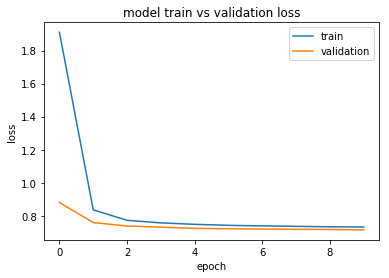

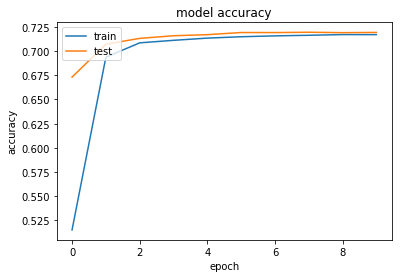

source 0 complete.
Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 53s 116us/step - loss: 1.8037 - acc: 0.5885 - categorical_accuracy: 0.5885 - val_loss: 0.8661 - val_acc: 0.6715 - val_categorical_accuracy: 0.6715
Epoch 2/10
461187/461187 [==============================] - 47s 101us/step - loss: 0.8295 - acc: 0.6908 - categorical_accuracy: 0.6908 - val_loss: 0.7638 - val_acc: 0.7097 - val_categorical_accuracy: 0.7097
Epoch 3/10
461187/461187 [==============================] - 46s 100us/step - loss: 0.7758 - acc: 0.7057 - categorical_accuracy: 0.7057 - val_loss: 0.7435 - val_acc: 0.7128 - val_categorical_accuracy: 0.7128
Epoch 4/10
461187/461187 [==============================] - 46s 101us/step - loss: 0.7601 - acc: 0.7090 - categorical_accuracy: 0.7090 - val_loss: 0.7341 - val_acc: 0.7154 - val_categorical_accuracy: 0.7154
Epoch 5/10
461187/461187 [==============================] - 46s 99us/step - loss: 0.7522 - acc: 0.7116

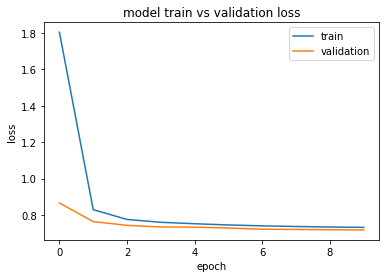

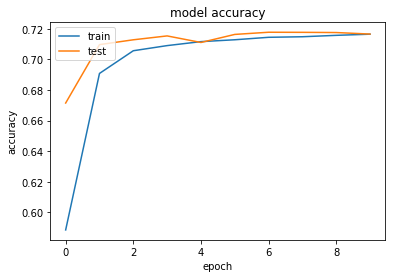

source 1 complete.
Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 54s 117us/step - loss: 1.8766 - acc: 0.5994 - categorical_accuracy: 0.5994 - val_loss: 0.8574 - val_acc: 0.6908 - val_categorical_accuracy: 0.6908
Epoch 2/10
461187/461187 [==============================] - 42s 90us/step - loss: 0.8215 - acc: 0.6978 - categorical_accuracy: 0.6978 - val_loss: 0.7534 - val_acc: 0.7123 - val_categorical_accuracy: 0.7123
Epoch 3/10
461187/461187 [==============================] - 41s 90us/step - loss: 0.7757 - acc: 0.7060 - categorical_accuracy: 0.7060 - val_loss: 0.7367 - val_acc: 0.7162 - val_categorical_accuracy: 0.7162
Epoch 4/10
461187/461187 [==============================] - 40s 87us/step - loss: 0.7622 - acc: 0.7090 - categorical_accuracy: 0.7090 - val_loss: 0.7303 - val_acc: 0.7170 - val_categorical_accuracy: 0.7170
Epoch 5/10
461187/461187 [==============================] - 43s 92us/step - loss: 0.7535 - acc: 0.7109 - 

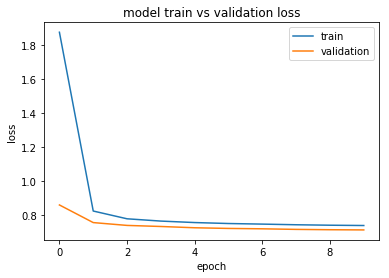

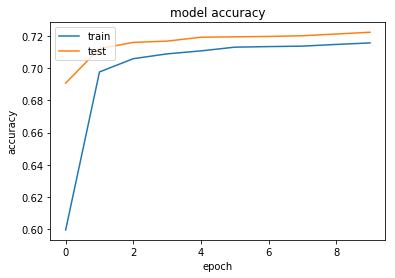

source 2 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 54s 118us/step - loss: 1.3863 - acc: 0.8115 - categorical_accuracy: 0.8115 - val_loss: 0.3079 - val_acc: 0.9115 - val_categorical_accuracy: 0.9115
Epoch 2/10
457255/457255 [==============================] - 46s 101us/step - loss: 0.2927 - acc: 0.9207 - categorical_accuracy: 0.9207 - val_loss: 0.2639 - val_acc: 0.9309 - val_categorical_accuracy: 0.9309
Epoch 3/10
457255/457255 [==============================] - 45s 99us/step - loss: 0.2668 - acc: 0.9300 - categorical_accuracy: 0.9300 - val_loss: 0.2509 - val_acc: 0.9330 - val_categorical_accuracy: 0.9330
Epoch 4/10
457255/457255 [==============================] - 45s 99us/step - loss: 0.2525 - acc: 0.9325 - categorical_accuracy: 0.9325 - val_loss: 0.2372 - val_acc: 0.9339 - val_categorical_accuracy: 0.9339
Epoch 5/10
457255/457255 [==============================] - 45s 99us/step - loss: 0.2400 - acc: 0.9345 -

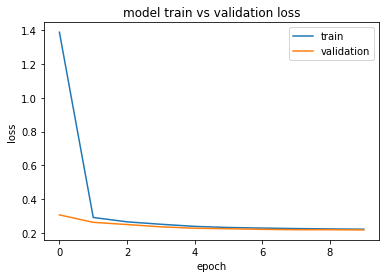

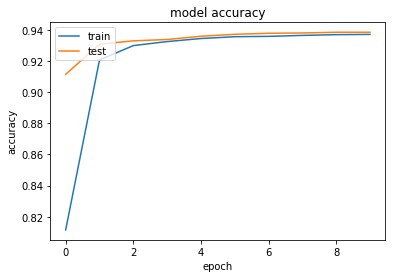

destination 0 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 44s 97us/step - loss: 1.3714 - acc: 0.8605 - categorical_accuracy: 0.8605 - val_loss: 0.2927 - val_acc: 0.9187 - val_categorical_accuracy: 0.9187
Epoch 2/10
457255/457255 [==============================] - 46s 100us/step - loss: 0.2933 - acc: 0.9222 - categorical_accuracy: 0.9222 - val_loss: 0.2575 - val_acc: 0.9263 - val_categorical_accuracy: 0.9263
Epoch 3/10
457255/457255 [==============================] - 47s 102us/step - loss: 0.2677 - acc: 0.9285 - categorical_accuracy: 0.9285 - val_loss: 0.2416 - val_acc: 0.9325 - val_categorical_accuracy: 0.9325
Epoch 4/10
457255/457255 [==============================] - 41s 89us/step - loss: 0.2522 - acc: 0.9323 - categorical_accuracy: 0.9323 - val_loss: 0.2307 - val_acc: 0.9338 - val_categorical_accuracy: 0.9338
Epoch 5/10
457255/457255 [==============================] - 41s 89us/step - loss: 0.2418 - acc: 0.9

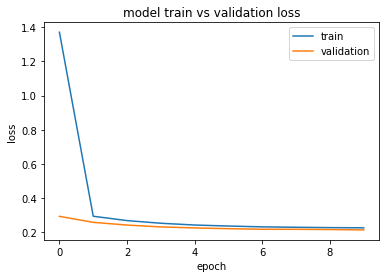

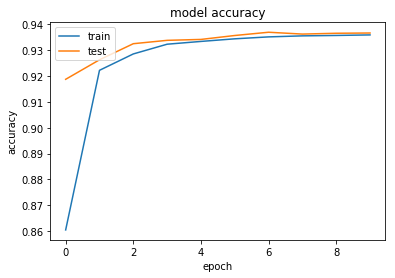

destination 1 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 53s 116us/step - loss: 1.4326 - acc: 0.8504 - categorical_accuracy: 0.8504 - val_loss: 0.2954 - val_acc: 0.9118 - val_categorical_accuracy: 0.9118
Epoch 2/10
457255/457255 [==============================] - 46s 101us/step - loss: 0.2884 - acc: 0.9239 - categorical_accuracy: 0.9239 - val_loss: 0.2545 - val_acc: 0.9299 - val_categorical_accuracy: 0.9299
Epoch 3/10
457255/457255 [==============================] - 45s 99us/step - loss: 0.2579 - acc: 0.9306 - categorical_accuracy: 0.9306 - val_loss: 0.2364 - val_acc: 0.9334 - val_categorical_accuracy: 0.9334
Epoch 4/10
457255/457255 [==============================] - 46s 101us/step - loss: 0.2449 - acc: 0.9328 - categorical_accuracy: 0.9328 - val_loss: 0.2290 - val_acc: 0.9358 - val_categorical_accuracy: 0.9358
Epoch 5/10
457255/457255 [==============================] - 44s 97us/step - loss: 0.2379 - acc: 0.

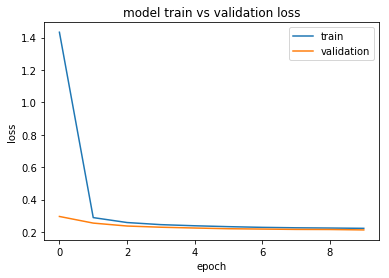

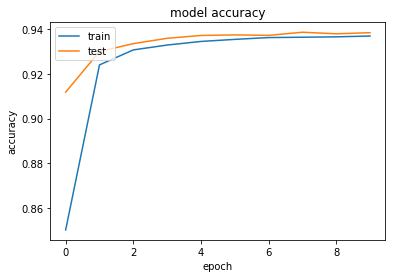

destination 2 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 51s 120us/step - loss: 1.4699 - acc: 0.8360 - categorical_accuracy: 0.8360 - val_loss: 0.1803 - val_acc: 0.9540 - val_categorical_accuracy: 0.9540
Epoch 2/10
423702/423702 [==============================] - 21s 49us/step - loss: 0.1822 - acc: 0.9555 - categorical_accuracy: 0.9555 - val_loss: 0.1452 - val_acc: 0.9628 - val_categorical_accuracy: 0.9628
Epoch 3/10
423702/423702 [==============================] - 22s 51us/step - loss: 0.1561 - acc: 0.9619 - categorical_accuracy: 0.9619 - val_loss: 0.1302 - val_acc: 0.9654 - val_categorical_accuracy: 0.9654
Epoch 4/10
423702/423702 [==============================] - 22s 53us/step - loss: 0.1431 - acc: 0.9640 - categorical_accuracy: 0.9640 - val_loss: 0.1241 - val_acc: 0.9669 - val_categorical_accuracy: 0.9669
Epoch 5/10
423702/423702 [==============================] - 22s 53us/step - loss: 0.1378 - acc: 0.96

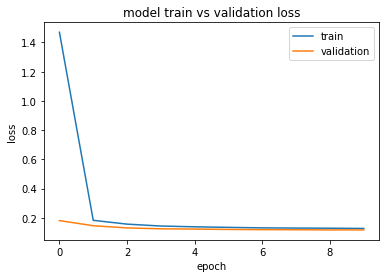

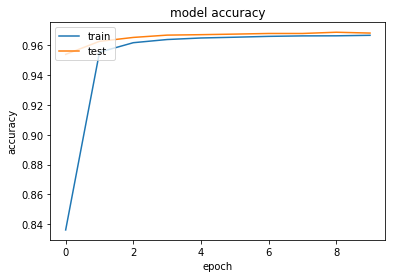

dyad 0 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 27s 63us/step - loss: 1.4204 - acc: 0.8881 - categorical_accuracy: 0.8881 - val_loss: 0.2075 - val_acc: 0.9444 - val_categorical_accuracy: 0.9444
Epoch 2/10
423702/423702 [==============================] - 28s 67us/step - loss: 0.1919 - acc: 0.9540 - categorical_accuracy: 0.9540 - val_loss: 0.1559 - val_acc: 0.9597 - val_categorical_accuracy: 0.9597
Epoch 3/10
423702/423702 [==============================] - 35s 82us/step - loss: 0.1600 - acc: 0.9611 - categorical_accuracy: 0.9611 - val_loss: 0.1403 - val_acc: 0.9626 - val_categorical_accuracy: 0.9626
Epoch 4/10
423702/423702 [==============================] - 32s 75us/step - loss: 0.1479 - acc: 0.9638 - categorical_accuracy: 0.9638 - val_loss: 0.1330 - val_acc: 0.9648 - val_categorical_accuracy: 0.9648
Epoch 5/10
423702/423702 [==============================] - 29s 69us/step - loss: 0.1407 - acc: 0.9649 - cat

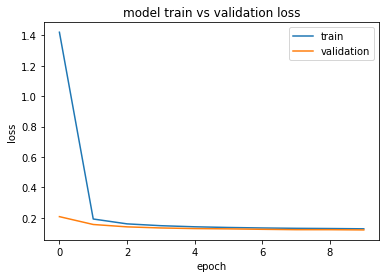

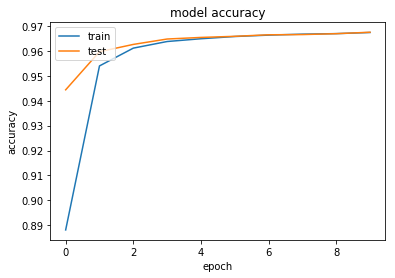

dyad 1 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 28s 65us/step - loss: 1.4787 - acc: 0.7944 - categorical_accuracy: 0.7944 - val_loss: 0.2177 - val_acc: 0.9436 - val_categorical_accuracy: 0.9436
Epoch 2/10
423702/423702 [==============================] - 28s 65us/step - loss: 0.2059 - acc: 0.9475 - categorical_accuracy: 0.9475 - val_loss: 0.1613 - val_acc: 0.9609 - val_categorical_accuracy: 0.9609
Epoch 3/10
423702/423702 [==============================] - 38s 90us/step - loss: 0.1672 - acc: 0.9591 - categorical_accuracy: 0.9591 - val_loss: 0.1444 - val_acc: 0.9624 - val_categorical_accuracy: 0.9624
Epoch 4/10
423702/423702 [==============================] - 33s 78us/step - loss: 0.1561 - acc: 0.9614 - categorical_accuracy: 0.9614 - val_loss: 0.1368 - val_acc: 0.9626 - val_categorical_accuracy: 0.9626
Epoch 5/10
423702/423702 [==============================] - 28s 66us/step - loss: 0.1494 - acc: 0.9631 - cat

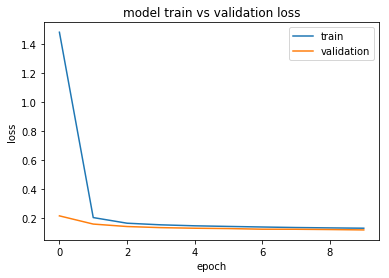

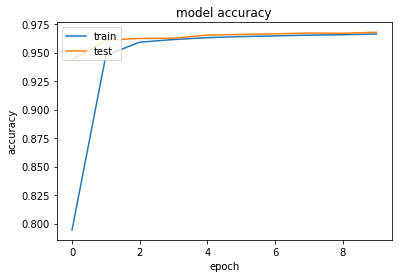

dyad 2 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 35s 74us/step - loss: 1.7886 - acc: 0.5822 - categorical_accuracy: 0.5822 - val_loss: 0.9166 - val_acc: 0.6612 - val_categorical_accuracy: 0.6612
Epoch 2/10
476604/476604 [==============================] - 37s 78us/step - loss: 0.8734 - acc: 0.6744 - categorical_accuracy: 0.6744 - val_loss: 0.8107 - val_acc: 0.6898 - val_categorical_accuracy: 0.6898
Epoch 3/10
476604/476604 [==============================] - 36s 75us/step - loss: 0.8186 - acc: 0.6856 - categorical_accuracy: 0.6856 - val_loss: 0.7957 - val_acc: 0.6901 - val_categorical_accuracy: 0.6901
Epoch 4/10
476604/476604 [==============================] - 33s 69us/step - loss: 0.8070 - acc: 0.6883 - categorical_accuracy: 0.6883 - val_loss: 0.7905 - val_acc: 0.6926 - val_categorical_accuracy: 0.6926
Epoch 5/10
476604/476604 [==============================] - 32s 67us/step - loss: 0.8007 - acc: 0.6899 - cat

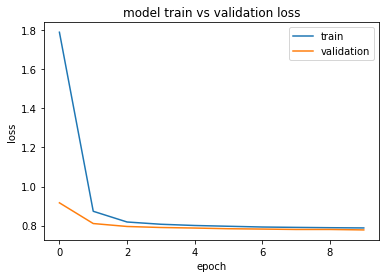

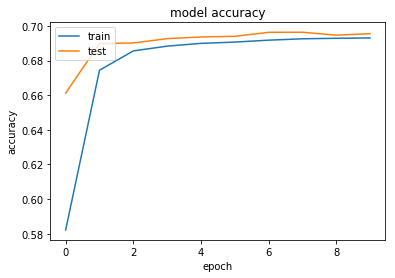

internal 0 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 31s 66us/step - loss: 1.7493 - acc: 0.5944 - categorical_accuracy: 0.5944 - val_loss: 0.9049 - val_acc: 0.6633 - val_categorical_accuracy: 0.6633
Epoch 2/10
476604/476604 [==============================] - 38s 80us/step - loss: 0.8753 - acc: 0.6728 - categorical_accuracy: 0.6728 - val_loss: 0.8216 - val_acc: 0.6872 - val_categorical_accuracy: 0.6872
Epoch 3/10
476604/476604 [==============================] - 38s 79us/step - loss: 0.8276 - acc: 0.6848 - categorical_accuracy: 0.6848 - val_loss: 0.8041 - val_acc: 0.6896 - val_categorical_accuracy: 0.6896
Epoch 4/10
476604/476604 [==============================] - 40s 85us/step - loss: 0.8100 - acc: 0.6883 - categorical_accuracy: 0.6883 - val_loss: 0.7916 - val_acc: 0.6934 - val_categorical_accuracy: 0.6934
Epoch 5/10
476604/476604 [==============================] - 41s 86us/step - loss: 0.8021 - acc: 0.6903 -

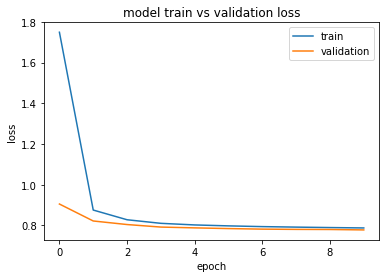

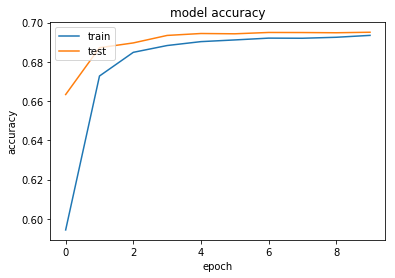

internal 1 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 34s 72us/step - loss: 1.7952 - acc: 0.5937 - categorical_accuracy: 0.5937 - val_loss: 0.9134 - val_acc: 0.6625 - val_categorical_accuracy: 0.6625
Epoch 2/10
476604/476604 [==============================] - 37s 77us/step - loss: 0.8834 - acc: 0.6690 - categorical_accuracy: 0.6690 - val_loss: 0.8052 - val_acc: 0.6897 - val_categorical_accuracy: 0.6897
Epoch 3/10
476604/476604 [==============================] - 34s 72us/step - loss: 0.8205 - acc: 0.6866 - categorical_accuracy: 0.6866 - val_loss: 0.7879 - val_acc: 0.6932 - val_categorical_accuracy: 0.6932
Epoch 4/10
476604/476604 [==============================] - 34s 71us/step - loss: 0.8075 - acc: 0.6893 - categorical_accuracy: 0.6893 - val_loss: 0.7842 - val_acc: 0.6931 - val_categorical_accuracy: 0.6931
Epoch 5/10
476604/476604 [==============================] - 41s 87us/step - loss: 0.8018 - acc: 0.6906 -

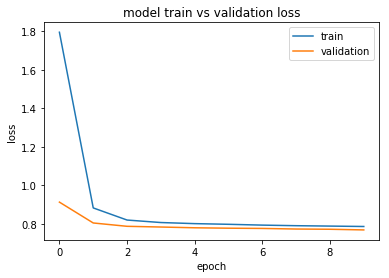

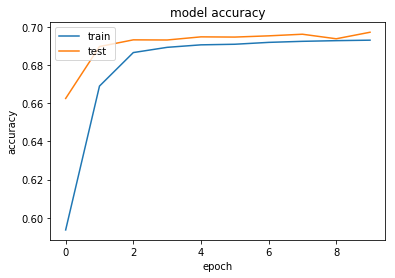

internal 2 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 36s 79us/step - loss: 1.3406 - acc: 0.8769 - categorical_accuracy: 0.8769 - val_loss: 0.2008 - val_acc: 0.9471 - val_categorical_accuracy: 0.9471
Epoch 2/10
457127/457127 [==============================] - 25s 55us/step - loss: 0.2024 - acc: 0.9519 - categorical_accuracy: 0.9519 - val_loss: 0.1682 - val_acc: 0.9577 - val_categorical_accuracy: 0.9577
Epoch 3/10
457127/457127 [==============================] - 30s 66us/step - loss: 0.1763 - acc: 0.9573 - categorical_accuracy: 0.9573 - val_loss: 0.1525 - val_acc: 0.9594 - val_categorical_accuracy: 0.9594
Epoch 4/10
457127/457127 [==============================] - 34s 74us/step - loss: 0.1659 - acc: 0.9588 - categorical_accuracy: 0.9588 - val_loss: 0.1454 - val_acc: 0.9616 - val_categorical_accuracy: 0.9616
Epoch 5/10
457127/457127 [==============================] - 33s 72us/step - loss: 0.1601 - acc: 0.9600 -

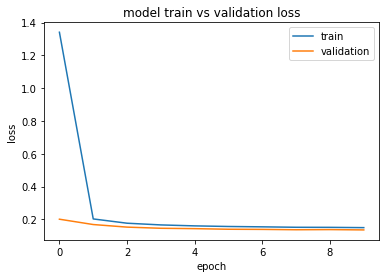

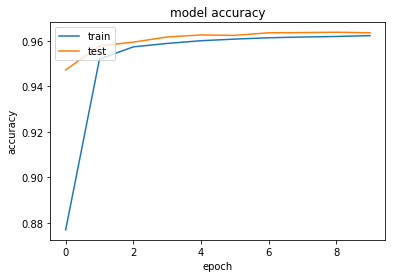

external 0 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 36s 80us/step - loss: 1.3537 - acc: 0.7903 - categorical_accuracy: 0.7903 - val_loss: 0.2348 - val_acc: 0.9287 - val_categorical_accuracy: 0.9287
Epoch 2/10
457127/457127 [==============================] - 32s 70us/step - loss: 0.2151 - acc: 0.9445 - categorical_accuracy: 0.9445 - val_loss: 0.1831 - val_acc: 0.9537 - val_categorical_accuracy: 0.9537
Epoch 3/10
457127/457127 [==============================] - 37s 81us/step - loss: 0.1827 - acc: 0.9556 - categorical_accuracy: 0.9556 - val_loss: 0.1683 - val_acc: 0.9574 - val_categorical_accuracy: 0.9574
Epoch 4/10
457127/457127 [==============================] - 39s 85us/step - loss: 0.1717 - acc: 0.9582 - categorical_accuracy: 0.9582 - val_loss: 0.1633 - val_acc: 0.9589 - val_categorical_accuracy: 0.9589
Epoch 5/10
457127/457127 [==============================] - 41s 91us/step - loss: 0.1654 - acc: 0.9591 -

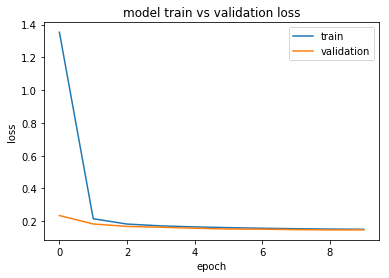

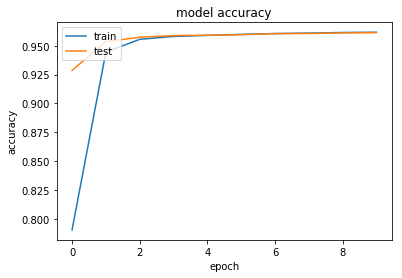

external 1 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 40s 87us/step - loss: 1.4068 - acc: 0.8165 - categorical_accuracy: 0.8165 - val_loss: 0.2291 - val_acc: 0.9323 - val_categorical_accuracy: 0.9323
Epoch 2/10
457127/457127 [==============================] - 30s 65us/step - loss: 0.2217 - acc: 0.9422 - categorical_accuracy: 0.9422 - val_loss: 0.1809 - val_acc: 0.9547 - val_categorical_accuracy: 0.9547
Epoch 3/10
457127/457127 [==============================] - 42s 91us/step - loss: 0.1896 - acc: 0.9545 - categorical_accuracy: 0.9545 - val_loss: 0.1656 - val_acc: 0.9572 - val_categorical_accuracy: 0.9572
Epoch 4/10
457127/457127 [==============================] - 44s 96us/step - loss: 0.1759 - acc: 0.9569 - categorical_accuracy: 0.9569 - val_loss: 0.1560 - val_acc: 0.9594 - val_categorical_accuracy: 0.9594
Epoch 5/10
457127/457127 [==============================] - 45s 99us/step - loss: 0.1676 - acc: 0.9586 -

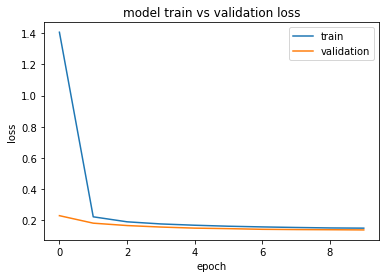

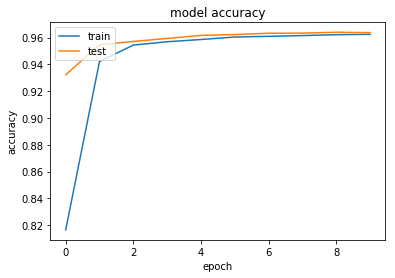

external 2 complete.


In [8]:
aggregations = ["source","destination","dyad","internal","external"]
# aggregations=["external"]

for agg in aggregations:

    cicids_testing = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/cicids_"+agg+"_hour_testing.pickle","rb"))
    cicids_training = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/cicids_"+agg+"_hour_training.pickle","rb"))

    X_test, Y_test, L_test = cicids_processing(cicids_testing["port_sequence"].tolist(),
                             cicids_testing["label_sequence"].tolist(),
                             len(port_fwd_dict)-1, seq_len, 3, False)

#     pickle.dump(X_test, open("results/"+agg+"_port_truth_X.pickle","wb"))
#     pickle.dump(Y_test, open("results/"+agg+"_port_truth_Y.pickle","wb"))
    pickle.dump(L_test, open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/final_baseline/"+agg+"_port_truth_L.pickle","wb"))

    for ii in range(num_models):

        X_train, Y_train, L_test = cicids_processing(cicids_training["port_sequence"].tolist(),
                             cicids_training["label_sequence"].tolist(),
                             len(port_fwd_dict)-1, seq_len, 1, True)
        
        model_input = Input(shape=(seq_len, ))
        embedding_a = Embedding(len(port_fwd_dict), 50, input_length=seq_len, mask_zero=True)(model_input)
        lstm_a = Bidirectional(GRU(25, return_sequences=True,implementation=2, reset_after=True, recurrent_activation='sigmoid'), merge_mode="concat")(embedding_a)
        dropout_a = Dropout(0.2)(lstm_a)
        lstm_b = Bidirectional(GRU(25, return_sequences=False, activation="relu", implementation=2, reset_after=True, recurrent_activation='sigmoid'), merge_mode="concat")(dropout_a)
        dropout_b = Dropout(0.2)(lstm_b)
        dense_layer = Dense(100, activation="linear")(dropout_b)
        dropout_c = Dropout(0.2)(dense_layer)
        model_output = Dense(len(port_fwd_dict)-1, activation="softmax")(dropout_c)
        
        model = Model(inputs=model_input, outputs=model_output)
        
      

        model.compile(optimizer=TFOptimizer(tf.contrib.opt.LazyAdamOptimizer()), loss='categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])

        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, class_weight = 'auto')
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model train vs validation loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
        
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        
        
        
        label_input = Input(shape=(len(port_fwd_dict)-1,))
        score_output = Dot(axes=(1,1))([model_output, label_input])
        pred_model = Model(inputs=[model_input,label_input], outputs=score_output)
        preds = pred_model.predict([X_test,Y_test], batch_size=batch_size)

        pickle.dump(preds,open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/final_baseline/"+agg+"_"+str(ii)+"_port_preds.pickle","wb"))

        print(agg + " " + str(ii) + " complete.")

Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 28s 62us/step - loss: 1.8558 - acc: 0.5788 - categorical_accuracy: 0.5788 - val_loss: 0.8753 - val_acc: 0.6735 - val_categorical_accuracy: 0.6735
Epoch 2/10
461187/461187 [==============================] - 23s 51us/step - loss: 0.8188 - acc: 0.7002 - categorical_accuracy: 0.7002 - val_loss: 0.7569 - val_acc: 0.7143 - val_categorical_accuracy: 0.7143
Epoch 3/10
461187/461187 [==============================] - 24s 53us/step - loss: 0.7679 - acc: 0.7099 - categorical_accuracy: 0.7099 - val_loss: 0.7411 - val_acc: 0.7176 - val_categorical_accuracy: 0.7176
Epoch 4/10
461187/461187 [==============================] - 24s 53us/step - loss: 0.7529 - acc: 0.7130 - categorical_accuracy: 0.7130 - val_loss: 0.7323 - val_acc: 0.7197 - val_categorical_accuracy: 0.7197
Epoch 5/10
461187/461187 [==============================] - 25s 53us/step - loss: 0.7446 - acc: 0.7146 - categorical_accuracy

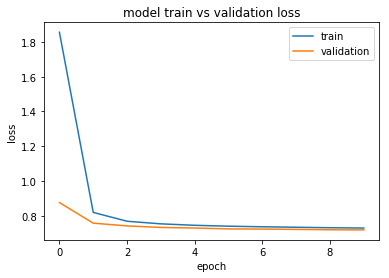

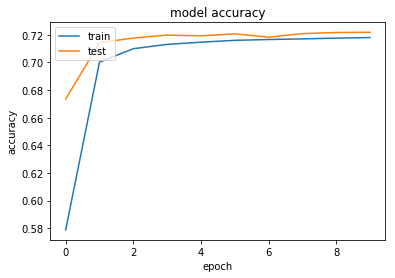

source 0 complete.
Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 28s 60us/step - loss: 1.8358 - acc: 0.6250 - categorical_accuracy: 0.6250 - val_loss: 0.8657 - val_acc: 0.6735 - val_categorical_accuracy: 0.6735
Epoch 2/10
461187/461187 [==============================] - 32s 68us/step - loss: 0.8293 - acc: 0.6986 - categorical_accuracy: 0.6986 - val_loss: 0.7594 - val_acc: 0.7124 - val_categorical_accuracy: 0.7124
Epoch 3/10
461187/461187 [==============================] - 31s 67us/step - loss: 0.7739 - acc: 0.7075 - categorical_accuracy: 0.7075 - val_loss: 0.7425 - val_acc: 0.7132 - val_categorical_accuracy: 0.7132
Epoch 4/10
461187/461187 [==============================] - 27s 58us/step - loss: 0.7606 - acc: 0.7101 - categorical_accuracy: 0.7101 - val_loss: 0.7348 - val_acc: 0.7151 - val_categorical_accuracy: 0.7151
Epoch 5/10
461187/461187 [==============================] - 32s 69us/step - loss: 0.7528 - acc: 0.7107 - c

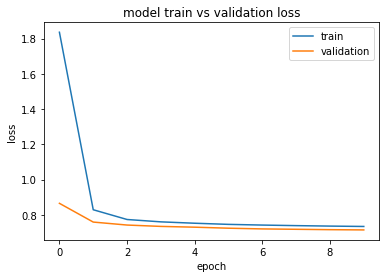

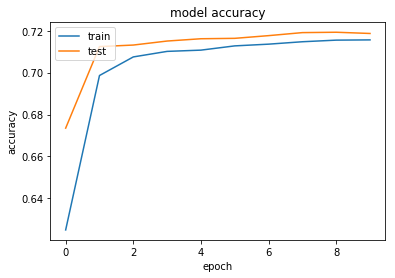

source 1 complete.
Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 28s 61us/step - loss: 1.7944 - acc: 0.5903 - categorical_accuracy: 0.5903 - val_loss: 0.8845 - val_acc: 0.6708 - val_categorical_accuracy: 0.6708
Epoch 2/10
461187/461187 [==============================] - 31s 67us/step - loss: 0.8298 - acc: 0.6957 - categorical_accuracy: 0.6957 - val_loss: 0.7724 - val_acc: 0.7063 - val_categorical_accuracy: 0.7063
Epoch 3/10
461187/461187 [==============================] - 30s 66us/step - loss: 0.7723 - acc: 0.7064 - categorical_accuracy: 0.7064 - val_loss: 0.7471 - val_acc: 0.7112 - val_categorical_accuracy: 0.7112
Epoch 4/10
461187/461187 [==============================] - 30s 65us/step - loss: 0.7570 - acc: 0.7102 - categorical_accuracy: 0.7102 - val_loss: 0.7412 - val_acc: 0.7133 - val_categorical_accuracy: 0.7133
Epoch 5/10
461187/461187 [==============================] - 33s 73us/step - loss: 0.7492 - acc: 0.7116 - c

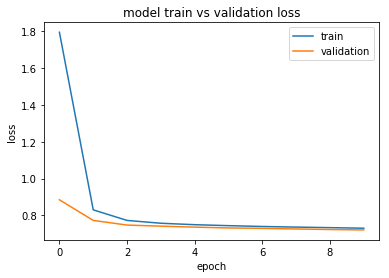

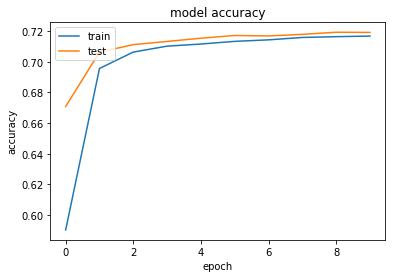

source 2 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 28s 62us/step - loss: 1.3715 - acc: 0.8506 - categorical_accuracy: 0.8506 - val_loss: 0.2881 - val_acc: 0.9120 - val_categorical_accuracy: 0.9120
Epoch 2/10
457255/457255 [==============================] - 28s 61us/step - loss: 0.2835 - acc: 0.9233 - categorical_accuracy: 0.9233 - val_loss: 0.2469 - val_acc: 0.9326 - val_categorical_accuracy: 0.9326
Epoch 3/10
457255/457255 [==============================] - 40s 87us/step - loss: 0.2552 - acc: 0.9314 - categorical_accuracy: 0.9314 - val_loss: 0.2348 - val_acc: 0.9341 - val_categorical_accuracy: 0.9341
Epoch 4/10
457255/457255 [==============================] - 25s 55us/step - loss: 0.2435 - acc: 0.9330 - categorical_accuracy: 0.9330 - val_loss: 0.2251 - val_acc: 0.9344 - val_categorical_accuracy: 0.9344
Epoch 5/10
457255/457255 [==============================] - 35s 75us/step - loss: 0.2373 - acc: 0.9340 - c

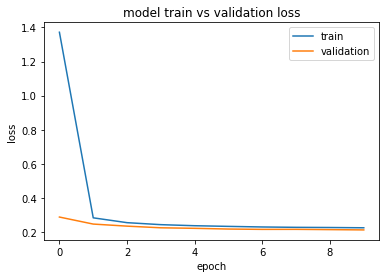

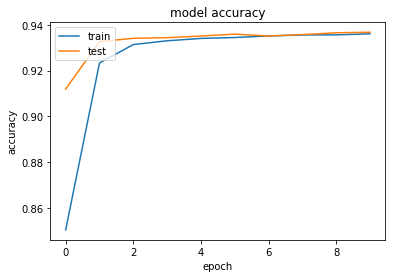

destination 0 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 32s 69us/step - loss: 1.3713 - acc: 0.8391 - categorical_accuracy: 0.8391 - val_loss: 0.3027 - val_acc: 0.9185 - val_categorical_accuracy: 0.9185
Epoch 2/10
457255/457255 [==============================] - 34s 74us/step - loss: 0.3015 - acc: 0.9193 - categorical_accuracy: 0.9193 - val_loss: 0.2559 - val_acc: 0.9308 - val_categorical_accuracy: 0.9308
Epoch 3/10
457255/457255 [==============================] - 30s 66us/step - loss: 0.2651 - acc: 0.9302 - categorical_accuracy: 0.9302 - val_loss: 0.2337 - val_acc: 0.9332 - val_categorical_accuracy: 0.9332
Epoch 4/10
457255/457255 [==============================] - 28s 61us/step - loss: 0.2499 - acc: 0.9315 - categorical_accuracy: 0.9315 - val_loss: 0.2260 - val_acc: 0.9358 - val_categorical_accuracy: 0.9358
Epoch 5/10
457255/457255 [==============================] - 31s 67us/step - loss: 0.2428 - acc: 0.932

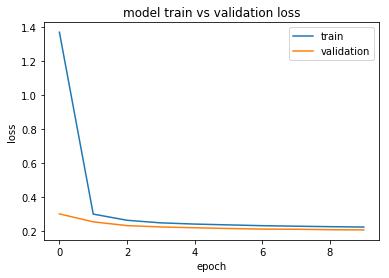

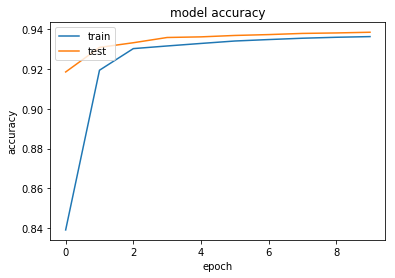

destination 1 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 28s 62us/step - loss: 1.3721 - acc: 0.7841 - categorical_accuracy: 0.7841 - val_loss: 0.3101 - val_acc: 0.9098 - val_categorical_accuracy: 0.9098
Epoch 2/10
457255/457255 [==============================] - 27s 59us/step - loss: 0.3046 - acc: 0.9176 - categorical_accuracy: 0.9176 - val_loss: 0.2720 - val_acc: 0.9258 - val_categorical_accuracy: 0.9258
Epoch 3/10
457255/457255 [==============================] - 36s 79us/step - loss: 0.2740 - acc: 0.9281 - categorical_accuracy: 0.9281 - val_loss: 0.2504 - val_acc: 0.9328 - val_categorical_accuracy: 0.9328
Epoch 4/10
457255/457255 [==============================] - 31s 69us/step - loss: 0.2547 - acc: 0.9319 - categorical_accuracy: 0.9319 - val_loss: 0.2363 - val_acc: 0.9352 - val_categorical_accuracy: 0.9352
Epoch 5/10
457255/457255 [==============================] - 35s 77us/step - loss: 0.2446 - acc: 0.932

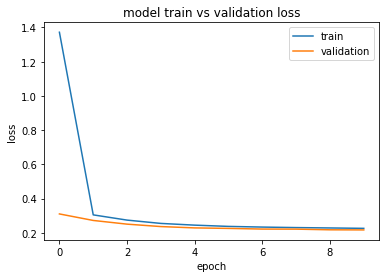

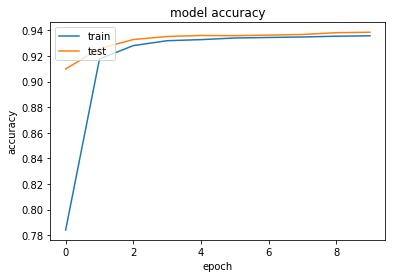

destination 2 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 32s 77us/step - loss: 1.4996 - acc: 0.8432 - categorical_accuracy: 0.8432 - val_loss: 0.2079 - val_acc: 0.9430 - val_categorical_accuracy: 0.9430
Epoch 2/10
423702/423702 [==============================] - 32s 76us/step - loss: 0.1948 - acc: 0.9513 - categorical_accuracy: 0.9513 - val_loss: 0.1496 - val_acc: 0.9596 - val_categorical_accuracy: 0.9596
Epoch 3/10
423702/423702 [==============================] - 35s 83us/step - loss: 0.1581 - acc: 0.9615 - categorical_accuracy: 0.9615 - val_loss: 0.1325 - val_acc: 0.9644 - val_categorical_accuracy: 0.9644
Epoch 4/10
423702/423702 [==============================] - 30s 70us/step - loss: 0.1461 - acc: 0.9638 - categorical_accuracy: 0.9638 - val_loss: 0.1269 - val_acc: 0.9657 - val_categorical_accuracy: 0.9657
Epoch 5/10
423702/423702 [==============================] - 34s 81us/step - loss: 0.1398 - acc: 0.964

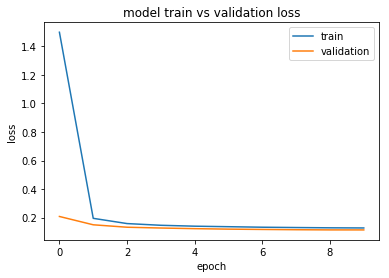

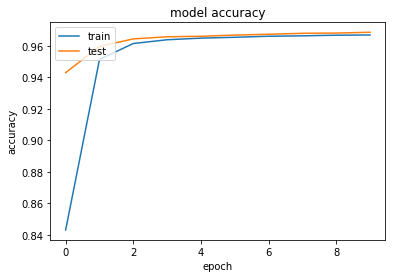

dyad 0 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 28s 67us/step - loss: 1.4534 - acc: 0.8391 - categorical_accuracy: 0.8391 - val_loss: 0.2162 - val_acc: 0.9411 - val_categorical_accuracy: 0.9411
Epoch 2/10
423702/423702 [==============================] - 27s 63us/step - loss: 0.1969 - acc: 0.9515 - categorical_accuracy: 0.9515 - val_loss: 0.1686 - val_acc: 0.9562 - val_categorical_accuracy: 0.9562
Epoch 3/10
423702/423702 [==============================] - 31s 74us/step - loss: 0.1644 - acc: 0.9599 - categorical_accuracy: 0.9599 - val_loss: 0.1523 - val_acc: 0.9604 - val_categorical_accuracy: 0.9604
Epoch 4/10
423702/423702 [==============================] - 33s 78us/step - loss: 0.1513 - acc: 0.9628 - categorical_accuracy: 0.9628 - val_loss: 0.1400 - val_acc: 0.9633 - val_categorical_accuracy: 0.9633
Epoch 5/10
423702/423702 [==============================] - 25s 59us/step - loss: 0.1428 - acc: 0.9641 - cat

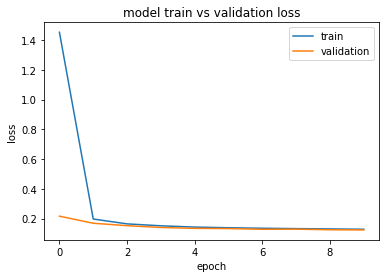

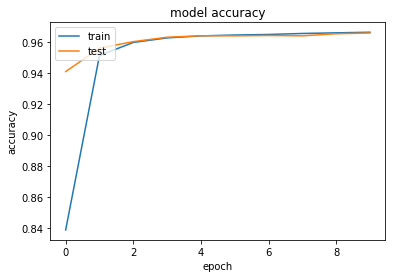

dyad 1 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 30s 70us/step - loss: 1.4237 - acc: 0.8261 - categorical_accuracy: 0.8261 - val_loss: 0.2192 - val_acc: 0.9420 - val_categorical_accuracy: 0.9420
Epoch 2/10
423702/423702 [==============================] - 32s 76us/step - loss: 0.1970 - acc: 0.9518 - categorical_accuracy: 0.9518 - val_loss: 0.1612 - val_acc: 0.9593 - val_categorical_accuracy: 0.9593
Epoch 3/10
423702/423702 [==============================] - 42s 98us/step - loss: 0.1625 - acc: 0.9610 - categorical_accuracy: 0.9610 - val_loss: 0.1418 - val_acc: 0.9631 - val_categorical_accuracy: 0.9631
Epoch 4/10
423702/423702 [==============================] - 38s 90us/step - loss: 0.1478 - acc: 0.9631 - categorical_accuracy: 0.9631 - val_loss: 0.1324 - val_acc: 0.9647 - val_categorical_accuracy: 0.9647
Epoch 5/10
423702/423702 [==============================] - 45s 105us/step - loss: 0.1407 - acc: 0.9641 - ca

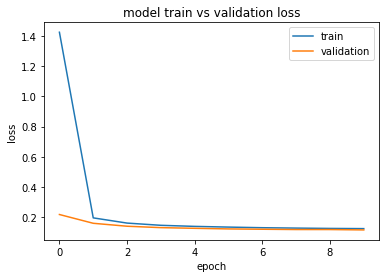

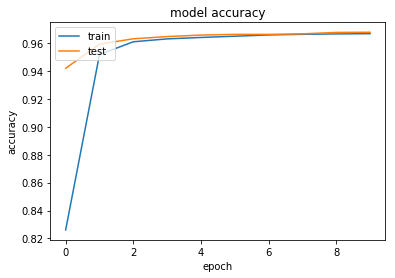

dyad 2 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 32s 68us/step - loss: 1.7820 - acc: 0.5569 - categorical_accuracy: 0.5569 - val_loss: 0.9110 - val_acc: 0.6586 - val_categorical_accuracy: 0.6586
Epoch 2/10
476604/476604 [==============================] - 27s 57us/step - loss: 0.8792 - acc: 0.6783 - categorical_accuracy: 0.6783 - val_loss: 0.8233 - val_acc: 0.6873 - val_categorical_accuracy: 0.6873
Epoch 3/10
476604/476604 [==============================] - 40s 83us/step - loss: 0.8279 - acc: 0.6854 - categorical_accuracy: 0.6854 - val_loss: 0.7988 - val_acc: 0.6888 - val_categorical_accuracy: 0.6888
Epoch 4/10
476604/476604 [==============================] - 32s 68us/step - loss: 0.8097 - acc: 0.6880 - categorical_accuracy: 0.6880 - val_loss: 0.7886 - val_acc: 0.6905 - val_categorical_accuracy: 0.6905
Epoch 5/10
476604/476604 [==============================] - 33s 70us/step - loss: 0.8023 - acc: 0.6901 - cat

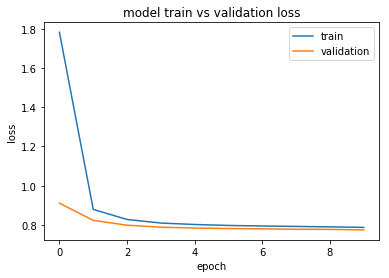

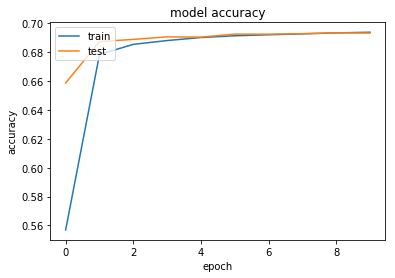

internal 0 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 32s 67us/step - loss: 1.8093 - acc: 0.5472 - categorical_accuracy: 0.5472 - val_loss: 0.8633 - val_acc: 0.6860 - val_categorical_accuracy: 0.6860
Epoch 2/10
476604/476604 [==============================] - 35s 73us/step - loss: 0.8677 - acc: 0.6787 - categorical_accuracy: 0.6787 - val_loss: 0.8097 - val_acc: 0.6899 - val_categorical_accuracy: 0.6899
Epoch 3/10
476604/476604 [==============================] - 46s 97us/step - loss: 0.8241 - acc: 0.6855 - categorical_accuracy: 0.6855 - val_loss: 0.7891 - val_acc: 0.6905 - val_categorical_accuracy: 0.6905
Epoch 4/10
476604/476604 [==============================] - 35s 73us/step - loss: 0.8087 - acc: 0.6876 - categorical_accuracy: 0.6876 - val_loss: 0.7833 - val_acc: 0.6924 - val_categorical_accuracy: 0.6924
Epoch 5/10
476604/476604 [==============================] - 36s 76us/step - loss: 0.8014 - acc: 0.6894 -

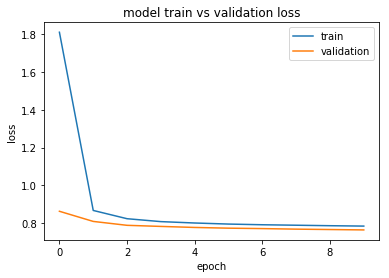

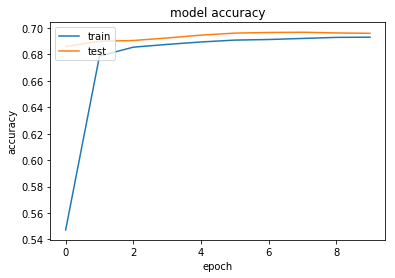

internal 1 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 33s 69us/step - loss: 1.8211 - acc: 0.5552 - categorical_accuracy: 0.5552 - val_loss: 0.9068 - val_acc: 0.6594 - val_categorical_accuracy: 0.6594
Epoch 2/10
476604/476604 [==============================] - 39s 83us/step - loss: 0.8881 - acc: 0.6710 - categorical_accuracy: 0.6710 - val_loss: 0.8211 - val_acc: 0.6848 - val_categorical_accuracy: 0.6848
Epoch 3/10
476604/476604 [==============================] - 36s 75us/step - loss: 0.8265 - acc: 0.6861 - categorical_accuracy: 0.6861 - val_loss: 0.7930 - val_acc: 0.6889 - val_categorical_accuracy: 0.6889
Epoch 4/10
476604/476604 [==============================] - 37s 77us/step - loss: 0.8097 - acc: 0.6878 - categorical_accuracy: 0.6878 - val_loss: 0.7846 - val_acc: 0.6910 - val_categorical_accuracy: 0.6910
Epoch 5/10
476604/476604 [==============================] - 37s 77us/step - loss: 0.8019 - acc: 0.6895 -

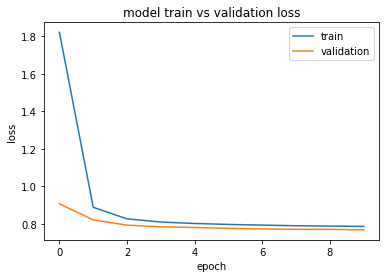

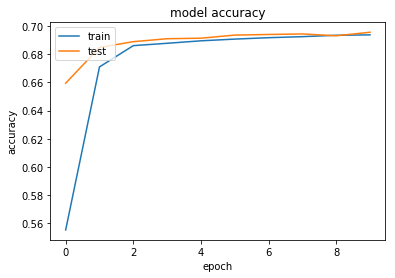

internal 2 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 36s 79us/step - loss: 1.4055 - acc: 0.7840 - categorical_accuracy: 0.7840 - val_loss: 0.2151 - val_acc: 0.9400 - val_categorical_accuracy: 0.9400
Epoch 2/10
457127/457127 [==============================] - 30s 66us/step - loss: 0.2005 - acc: 0.9509 - categorical_accuracy: 0.9509 - val_loss: 0.1604 - val_acc: 0.9592 - val_categorical_accuracy: 0.9592
Epoch 3/10
457127/457127 [==============================] - 32s 71us/step - loss: 0.1698 - acc: 0.9580 - categorical_accuracy: 0.9580 - val_loss: 0.1511 - val_acc: 0.9609 - val_categorical_accuracy: 0.9609
Epoch 4/10
457127/457127 [==============================] - 36s 79us/step - loss: 0.1615 - acc: 0.9595 - categorical_accuracy: 0.9595 - val_loss: 0.1472 - val_acc: 0.9616 - val_categorical_accuracy: 0.9616
Epoch 5/10
457127/457127 [==============================] - 30s 66us/step - loss: 0.1569 - acc: 0.9603 -

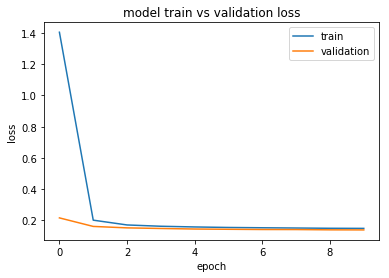

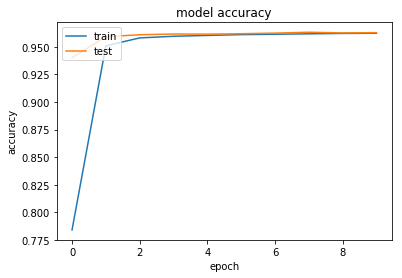

external 0 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 31s 69us/step - loss: 1.3824 - acc: 0.8679 - categorical_accuracy: 0.8679 - val_loss: 0.2236 - val_acc: 0.9396 - val_categorical_accuracy: 0.9396
Epoch 2/10
457127/457127 [==============================] - 32s 70us/step - loss: 0.2105 - acc: 0.9473 - categorical_accuracy: 0.9473 - val_loss: 0.1847 - val_acc: 0.9547 - val_categorical_accuracy: 0.9547
Epoch 3/10
457127/457127 [==============================] - 37s 82us/step - loss: 0.1822 - acc: 0.9559 - categorical_accuracy: 0.9559 - val_loss: 0.1685 - val_acc: 0.9589 - val_categorical_accuracy: 0.9589
Epoch 4/10
457127/457127 [==============================] - 36s 79us/step - loss: 0.1688 - acc: 0.9589 - categorical_accuracy: 0.9589 - val_loss: 0.1595 - val_acc: 0.9596 - val_categorical_accuracy: 0.9596
Epoch 5/10
457127/457127 [==============================] - 38s 82us/step - loss: 0.1616 - acc: 0.9599 -

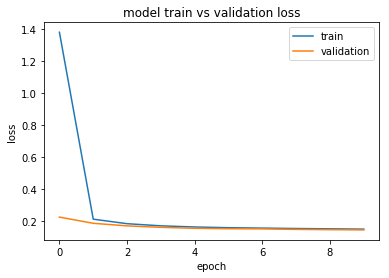

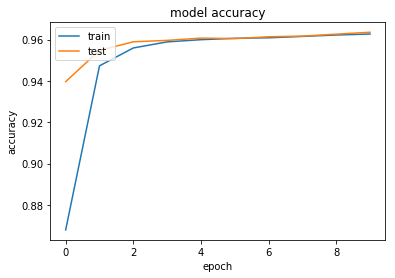

external 1 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 35s 76us/step - loss: 1.3948 - acc: 0.7943 - categorical_accuracy: 0.7943 - val_loss: 0.2167 - val_acc: 0.9450 - val_categorical_accuracy: 0.9450
Epoch 2/10
457127/457127 [==============================] - 40s 88us/step - loss: 0.1960 - acc: 0.9531 - categorical_accuracy: 0.9531 - val_loss: 0.1746 - val_acc: 0.9553 - val_categorical_accuracy: 0.9553
Epoch 3/10
457127/457127 [==============================] - 35s 76us/step - loss: 0.1747 - acc: 0.9568 - categorical_accuracy: 0.9568 - val_loss: 0.1616 - val_acc: 0.9589 - val_categorical_accuracy: 0.9589
Epoch 4/10
457127/457127 [==============================] - 39s 85us/step - loss: 0.1648 - acc: 0.9590 - categorical_accuracy: 0.9590 - val_loss: 0.1547 - val_acc: 0.9594 - val_categorical_accuracy: 0.9594
Epoch 5/10
457127/457127 [==============================] - 41s 89us/step - loss: 0.1591 - acc: 0.9598 -

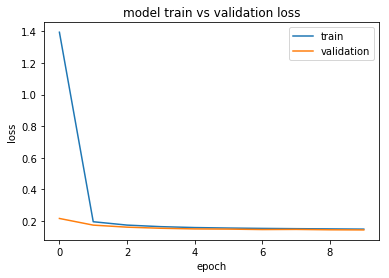

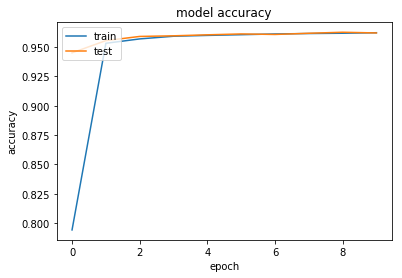

external 2 complete.


In [5]:
aggregations = ["source","destination","dyad","internal","external"]
# aggregations=["external"]

for agg in aggregations:

    cicids_testing = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/cicids_"+agg+"_hour_testing.pickle","rb"))
    cicids_training = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/cicids_"+agg+"_hour_training.pickle","rb"))

    X_test, Y_test, L_test = cicids_processing(cicids_testing["port_sequence"].tolist(),
                             cicids_testing["label_sequence"].tolist(),
                             len(port_fwd_dict)-1, seq_len, 3, False)

#     pickle.dump(X_test, open("results/"+agg+"_port_truth_X.pickle","wb"))
#     pickle.dump(Y_test, open("results/"+agg+"_port_truth_Y.pickle","wb"))
    pickle.dump(L_test, open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/gru_baseline_lstm/"+agg+"_port_truth_L.pickle","wb"))

    for ii in range(num_models):

        X_train, Y_train, L_test = cicids_processing(cicids_training["port_sequence"].tolist(),
                             cicids_training["label_sequence"].tolist(),
                             len(port_fwd_dict)-1, seq_len, 1, True)

        
        model_input = Input(shape=(seq_len, ))
        embedding_a = Embedding(len(port_fwd_dict), 50, input_length=seq_len, mask_zero=True)(model_input)
        lstm_a = Bidirectional(GRU(25, return_sequences=True,implementation=2, reset_after=True, recurrent_activation='sigmoid'), merge_mode="concat")(embedding_a)
        dropout_a = Dropout(0.2)(lstm_a)
        lstm_b = Bidirectional(GRU(25, return_sequences=False, activation="relu", implementation=2, reset_after=True, recurrent_activation='sigmoid'), merge_mode="concat")(dropout_a)
        dropout_b = Dropout(0.2)(lstm_b)
        dense_layer = Dense(100, activation="linear")(dropout_b)
        dropout_c = Dropout(0.2)(dense_layer)
        model_output = Dense(len(port_fwd_dict)-1, activation="softmax")(dropout_c)

        model = Model(inputs=model_input, outputs=model_output)
        model.compile(optimizer=TFOptimizer(tf.contrib.opt.LazyAdamOptimizer()), loss='categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])

        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, class_weight = 'auto')
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model train vs validation loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
        
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        
        
        
        label_input = Input(shape=(len(port_fwd_dict)-1,))
        score_output = Dot(axes=(1,1))([model_output, label_input])
        pred_model = Model(inputs=[model_input,label_input], outputs=score_output)
        preds = pred_model.predict([X_test,Y_test], batch_size=batch_size)

        pickle.dump(preds,open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/gru_baseline_lstm/"+agg+"_"+str(ii)+"_port_preds.pickle","wb"))

        print(agg + " " + str(ii) + " complete.")

Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 39s 84us/step - loss: 2.2154 - acc: 0.3774 - categorical_accuracy: 0.3774 - val_loss: 1.8212 - val_acc: 0.4453 - val_categorical_accuracy: 0.4453
Epoch 2/10
461187/461187 [==============================] - 26s 56us/step - loss: 1.8413 - acc: 0.4411 - categorical_accuracy: 0.4411 - val_loss: 1.7757 - val_acc: 0.4534 - val_categorical_accuracy: 0.4534
Epoch 3/10
461187/461187 [==============================] - 22s 47us/step - loss: 1.8062 - acc: 0.4487 - categorical_accuracy: 0.4487 - val_loss: 1.7581 - val_acc: 0.4560 - val_categorical_accuracy: 0.4560
Epoch 4/10
461187/461187 [==============================] - 34s 73us/step - loss: 1.7875 - acc: 0.4521 - categorical_accuracy: 0.4521 - val_loss: 1.7460 - val_acc: 0.4558 - val_categorical_accuracy: 0.4558
Epoch 5/10
461187/461187 [==============================] - 29s 62us/step - loss: 1.7764 - acc: 0.4533 - categorical_accuracy

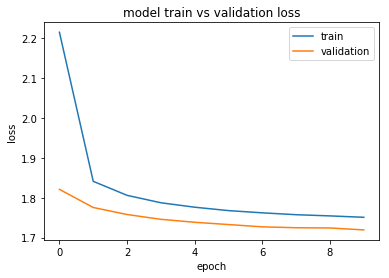

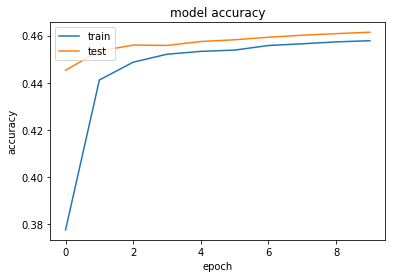

source 0 complete.
Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 33s 72us/step - loss: 2.1991 - acc: 0.3744 - categorical_accuracy: 0.3744 - val_loss: 1.8289 - val_acc: 0.4425 - val_categorical_accuracy: 0.4425
Epoch 2/10
461187/461187 [==============================] - 29s 62us/step - loss: 1.8411 - acc: 0.4403 - categorical_accuracy: 0.4403 - val_loss: 1.7700 - val_acc: 0.4575 - val_categorical_accuracy: 0.4575
Epoch 3/10
461187/461187 [==============================] - 36s 77us/step - loss: 1.8029 - acc: 0.4479 - categorical_accuracy: 0.4479 - val_loss: 1.7487 - val_acc: 0.4581 - val_categorical_accuracy: 0.4581
Epoch 4/10
461187/461187 [==============================] - 24s 52us/step - loss: 1.7840 - acc: 0.4508 - categorical_accuracy: 0.4508 - val_loss: 1.7372 - val_acc: 0.4598 - val_categorical_accuracy: 0.4598
Epoch 5/10
461187/461187 [==============================] - 29s 62us/step - loss: 1.7727 - acc: 0.4528 - c

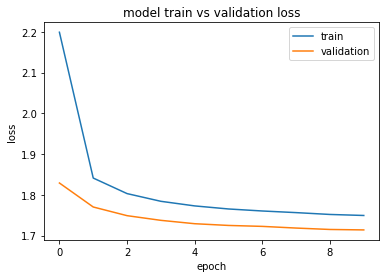

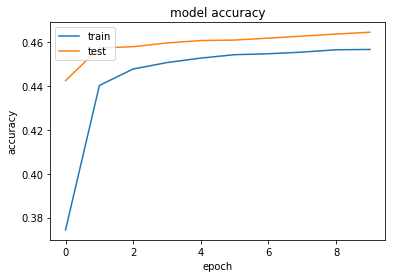

source 1 complete.
Train on 461187 samples, validate on 51243 samples
Epoch 1/10
461187/461187 [==============================] - 39s 84us/step - loss: 2.2074 - acc: 0.3755 - categorical_accuracy: 0.3755 - val_loss: 1.8261 - val_acc: 0.4463 - val_categorical_accuracy: 0.4463
Epoch 2/10
461187/461187 [==============================] - 40s 87us/step - loss: 1.8435 - acc: 0.4388 - categorical_accuracy: 0.4388 - val_loss: 1.7700 - val_acc: 0.4547 - val_categorical_accuracy: 0.4547
Epoch 3/10
461187/461187 [==============================] - 28s 60us/step - loss: 1.8059 - acc: 0.4468 - categorical_accuracy: 0.4468 - val_loss: 1.7487 - val_acc: 0.4562 - val_categorical_accuracy: 0.4562
Epoch 4/10
461187/461187 [==============================] - 23s 50us/step - loss: 1.7839 - acc: 0.4506 - categorical_accuracy: 0.4506 - val_loss: 1.7336 - val_acc: 0.4594 - val_categorical_accuracy: 0.4594
Epoch 5/10
461187/461187 [==============================] - 36s 78us/step - loss: 1.7724 - acc: 0.4526 - c

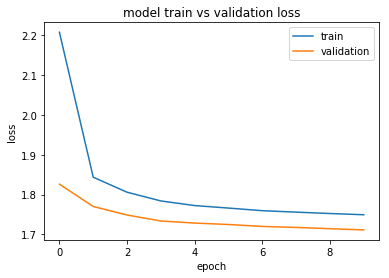

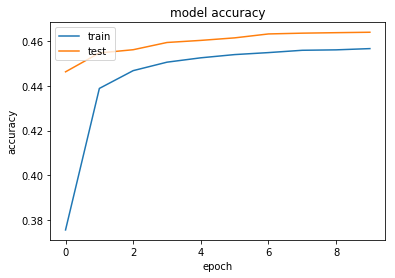

source 2 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 33s 73us/step - loss: 1.8610 - acc: 0.4370 - categorical_accuracy: 0.4370 - val_loss: 1.4160 - val_acc: 0.5258 - val_categorical_accuracy: 0.5258
Epoch 2/10
457255/457255 [==============================] - 21s 47us/step - loss: 1.4092 - acc: 0.5228 - categorical_accuracy: 0.5228 - val_loss: 1.3374 - val_acc: 0.5379 - val_categorical_accuracy: 0.5379
Epoch 3/10
457255/457255 [==============================] - 35s 77us/step - loss: 1.3645 - acc: 0.5317 - categorical_accuracy: 0.5317 - val_loss: 1.3189 - val_acc: 0.5389 - val_categorical_accuracy: 0.5389
Epoch 4/10
457255/457255 [==============================] - 24s 53us/step - loss: 1.3446 - acc: 0.5357 - categorical_accuracy: 0.5357 - val_loss: 1.3042 - val_acc: 0.5427 - val_categorical_accuracy: 0.5427
Epoch 5/10
457255/457255 [==============================] - 36s 79us/step - loss: 1.3310 - acc: 0.5390 - c

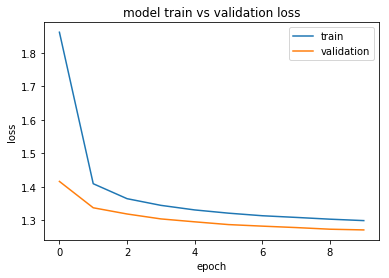

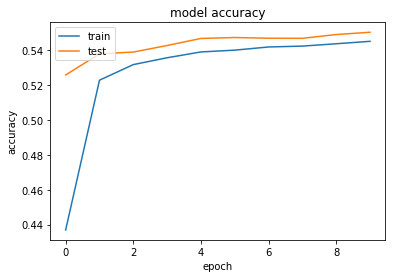

destination 0 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 32s 70us/step - loss: 1.8667 - acc: 0.4523 - categorical_accuracy: 0.4523 - val_loss: 1.3855 - val_acc: 0.5343 - val_categorical_accuracy: 0.5343
Epoch 2/10
457255/457255 [==============================] - 30s 65us/step - loss: 1.4155 - acc: 0.5251 - categorical_accuracy: 0.5251 - val_loss: 1.3228 - val_acc: 0.5434 - val_categorical_accuracy: 0.5434
Epoch 3/10
457255/457255 [==============================] - 32s 69us/step - loss: 1.3691 - acc: 0.5331 - categorical_accuracy: 0.5331 - val_loss: 1.2984 - val_acc: 0.5458 - val_categorical_accuracy: 0.5458
Epoch 4/10
457255/457255 [==============================] - 25s 55us/step - loss: 1.3473 - acc: 0.5366 - categorical_accuracy: 0.5366 - val_loss: 1.2854 - val_acc: 0.5498 - val_categorical_accuracy: 0.5498
Epoch 5/10
457255/457255 [==============================] - 28s 60us/step - loss: 1.3342 - acc: 0.538

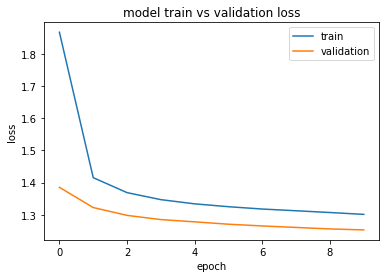

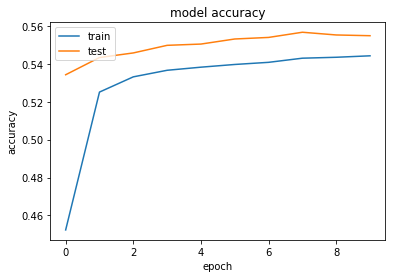

destination 1 complete.
Train on 457255 samples, validate on 50807 samples
Epoch 1/10
457255/457255 [==============================] - 33s 72us/step - loss: 1.8591 - acc: 0.4397 - categorical_accuracy: 0.4397 - val_loss: 1.4154 - val_acc: 0.5273 - val_categorical_accuracy: 0.5273
Epoch 2/10
457255/457255 [==============================] - 32s 69us/step - loss: 1.4249 - acc: 0.5230 - categorical_accuracy: 0.5230 - val_loss: 1.3374 - val_acc: 0.5396 - val_categorical_accuracy: 0.5396
Epoch 3/10
457255/457255 [==============================] - 26s 56us/step - loss: 1.3722 - acc: 0.5331 - categorical_accuracy: 0.5331 - val_loss: 1.3147 - val_acc: 0.5439 - val_categorical_accuracy: 0.5439
Epoch 4/10
457255/457255 [==============================] - 32s 71us/step - loss: 1.3491 - acc: 0.5368 - categorical_accuracy: 0.5368 - val_loss: 1.3017 - val_acc: 0.5443 - val_categorical_accuracy: 0.5443
Epoch 5/10
457255/457255 [==============================] - 35s 77us/step - loss: 1.3353 - acc: 0.539

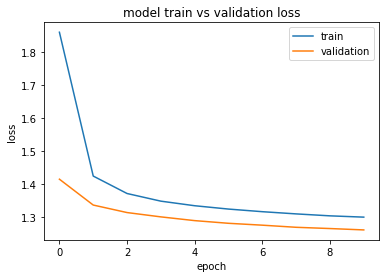

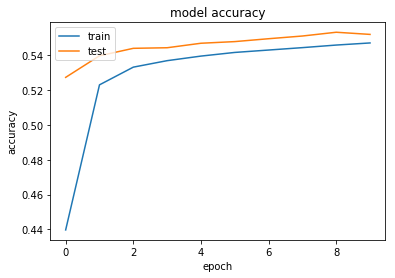

destination 2 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 25s 59us/step - loss: 1.8467 - acc: 0.4487 - categorical_accuracy: 0.4487 - val_loss: 1.2564 - val_acc: 0.5706 - val_categorical_accuracy: 0.5706
Epoch 2/10
423702/423702 [==============================] - 19s 44us/step - loss: 1.2762 - acc: 0.5667 - categorical_accuracy: 0.5667 - val_loss: 1.2008 - val_acc: 0.5805 - val_categorical_accuracy: 0.5805
Epoch 3/10
423702/423702 [==============================] - 27s 63us/step - loss: 1.2385 - acc: 0.5731 - categorical_accuracy: 0.5731 - val_loss: 1.1830 - val_acc: 0.5810 - val_categorical_accuracy: 0.5810
Epoch 4/10
423702/423702 [==============================] - 26s 62us/step - loss: 1.2189 - acc: 0.5765 - categorical_accuracy: 0.5765 - val_loss: 1.1705 - val_acc: 0.5834 - val_categorical_accuracy: 0.5834
Epoch 5/10
423702/423702 [==============================] - 19s 46us/step - loss: 1.2062 - acc: 0.578

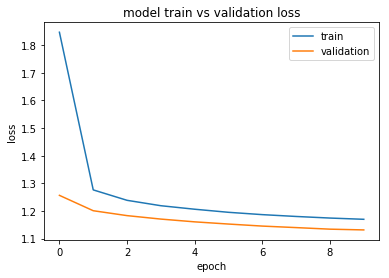

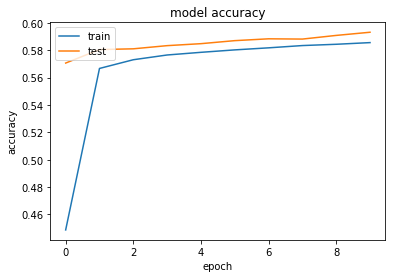

dyad 0 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 38s 89us/step - loss: 1.8134 - acc: 0.4663 - categorical_accuracy: 0.4663 - val_loss: 1.2868 - val_acc: 0.5686 - val_categorical_accuracy: 0.5686
Epoch 2/10
423702/423702 [==============================] - 24s 58us/step - loss: 1.2946 - acc: 0.5620 - categorical_accuracy: 0.5620 - val_loss: 1.2080 - val_acc: 0.5790 - val_categorical_accuracy: 0.5790
Epoch 3/10
423702/423702 [==============================] - 22s 53us/step - loss: 1.2419 - acc: 0.5716 - categorical_accuracy: 0.5716 - val_loss: 1.1839 - val_acc: 0.5839 - val_categorical_accuracy: 0.5839
Epoch 4/10
423702/423702 [==============================] - 28s 65us/step - loss: 1.2205 - acc: 0.5747 - categorical_accuracy: 0.5747 - val_loss: 1.1686 - val_acc: 0.5835 - val_categorical_accuracy: 0.5835
Epoch 5/10
423702/423702 [==============================] - 25s 59us/step - loss: 1.2062 - acc: 0.5775 - cat

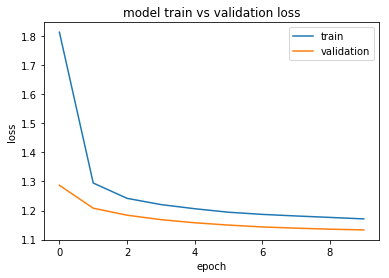

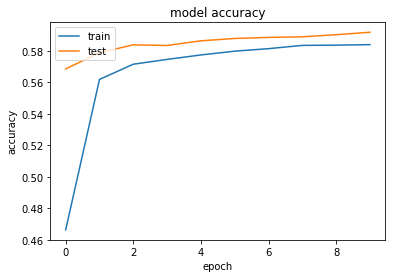

dyad 1 complete.
Train on 423702 samples, validate on 47079 samples
Epoch 1/10
423702/423702 [==============================] - 37s 88us/step - loss: 1.8186 - acc: 0.4616 - categorical_accuracy: 0.4616 - val_loss: 1.2823 - val_acc: 0.5679 - val_categorical_accuracy: 0.5679
Epoch 2/10
423702/423702 [==============================] - 18s 41us/step - loss: 1.2953 - acc: 0.5612 - categorical_accuracy: 0.5612 - val_loss: 1.2077 - val_acc: 0.5799 - val_categorical_accuracy: 0.5799
Epoch 3/10
423702/423702 [==============================] - 26s 61us/step - loss: 1.2452 - acc: 0.5708 - categorical_accuracy: 0.5708 - val_loss: 1.1809 - val_acc: 0.5835 - val_categorical_accuracy: 0.5835
Epoch 4/10
423702/423702 [==============================] - 26s 61us/step - loss: 1.2221 - acc: 0.5755 - categorical_accuracy: 0.5755 - val_loss: 1.1675 - val_acc: 0.5886 - val_categorical_accuracy: 0.5886
Epoch 5/10
423702/423702 [==============================] - 25s 59us/step - loss: 1.2094 - acc: 0.5780 - cat

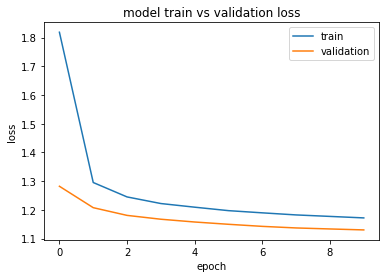

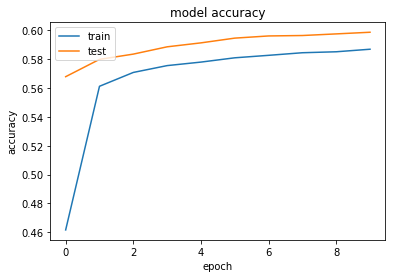

dyad 2 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 28s 58us/step - loss: 2.3308 - acc: 0.3355 - categorical_accuracy: 0.3355 - val_loss: 1.9803 - val_acc: 0.4065 - val_categorical_accuracy: 0.4065
Epoch 2/10
476604/476604 [==============================] - 20s 43us/step - loss: 2.0113 - acc: 0.3982 - categorical_accuracy: 0.3982 - val_loss: 1.9501 - val_acc: 0.4083 - val_categorical_accuracy: 0.4083
Epoch 3/10
476604/476604 [==============================] - 28s 59us/step - loss: 1.9831 - acc: 0.4017 - categorical_accuracy: 0.4017 - val_loss: 1.9331 - val_acc: 0.4094 - val_categorical_accuracy: 0.4094
Epoch 4/10
476604/476604 [==============================] - 28s 59us/step - loss: 1.9669 - acc: 0.4046 - categorical_accuracy: 0.4046 - val_loss: 1.9240 - val_acc: 0.4099 - val_categorical_accuracy: 0.4099
Epoch 5/10
476604/476604 [==============================] - 21s 45us/step - loss: 1.9564 - acc: 0.4058 - cat

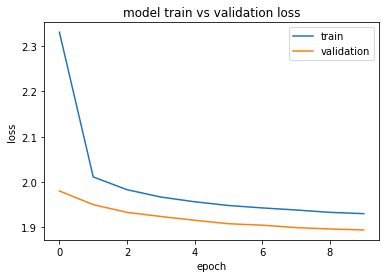

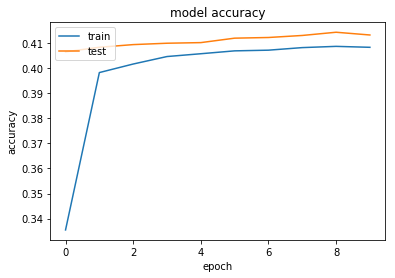

internal 0 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 35s 74us/step - loss: 2.3354 - acc: 0.3359 - categorical_accuracy: 0.3359 - val_loss: 2.0099 - val_acc: 0.3966 - val_categorical_accuracy: 0.3966
Epoch 2/10
476604/476604 [==============================] - 23s 49us/step - loss: 2.0248 - acc: 0.3957 - categorical_accuracy: 0.3957 - val_loss: 1.9578 - val_acc: 0.4068 - val_categorical_accuracy: 0.4068
Epoch 3/10
476604/476604 [==============================] - 37s 78us/step - loss: 1.9880 - acc: 0.4016 - categorical_accuracy: 0.4016 - val_loss: 1.9359 - val_acc: 0.4099 - val_categorical_accuracy: 0.4099
Epoch 4/10
476604/476604 [==============================] - 33s 69us/step - loss: 1.9683 - acc: 0.4037 - categorical_accuracy: 0.4037 - val_loss: 1.9228 - val_acc: 0.4116 - val_categorical_accuracy: 0.4116
Epoch 5/10
476604/476604 [==============================] - 23s 47us/step - loss: 1.9570 - acc: 0.4058 -

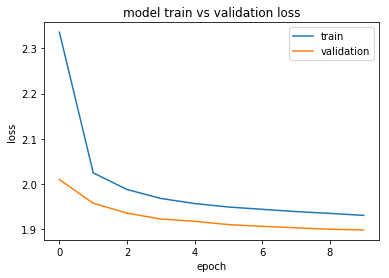

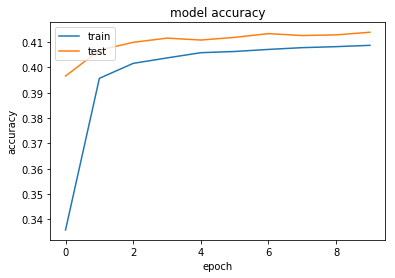

internal 1 complete.
Train on 476604 samples, validate on 52956 samples
Epoch 1/10
476604/476604 [==============================] - 37s 78us/step - loss: 2.3260 - acc: 0.3357 - categorical_accuracy: 0.3357 - val_loss: 1.9923 - val_acc: 0.4026 - val_categorical_accuracy: 0.4026
Epoch 2/10
476604/476604 [==============================] - 27s 56us/step - loss: 2.0136 - acc: 0.3981 - categorical_accuracy: 0.3981 - val_loss: 1.9506 - val_acc: 0.4077 - val_categorical_accuracy: 0.4077
Epoch 3/10
476604/476604 [==============================] - 28s 58us/step - loss: 1.9813 - acc: 0.4025 - categorical_accuracy: 0.4025 - val_loss: 1.9273 - val_acc: 0.4103 - val_categorical_accuracy: 0.4103
Epoch 4/10
476604/476604 [==============================] - 24s 49us/step - loss: 1.9644 - acc: 0.4040 - categorical_accuracy: 0.4040 - val_loss: 1.9178 - val_acc: 0.4114 - val_categorical_accuracy: 0.4114
Epoch 5/10
476604/476604 [==============================] - 27s 56us/step - loss: 1.9538 - acc: 0.4056 -

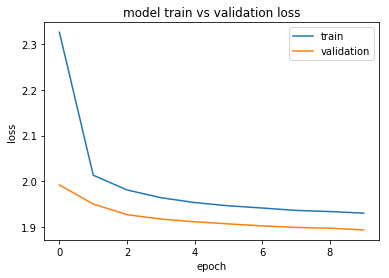

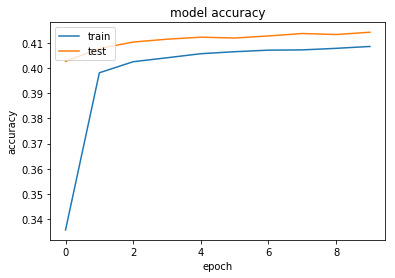

internal 2 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 31s 67us/step - loss: 1.9682 - acc: 0.4237 - categorical_accuracy: 0.4237 - val_loss: 1.5593 - val_acc: 0.4912 - val_categorical_accuracy: 0.4912
Epoch 2/10
457127/457127 [==============================] - 27s 60us/step - loss: 1.5558 - acc: 0.4862 - categorical_accuracy: 0.4862 - val_loss: 1.4731 - val_acc: 0.5010 - val_categorical_accuracy: 0.5010
Epoch 3/10
457127/457127 [==============================] - 32s 70us/step - loss: 1.5029 - acc: 0.4923 - categorical_accuracy: 0.4923 - val_loss: 1.4453 - val_acc: 0.5031 - val_categorical_accuracy: 0.5031
Epoch 4/10
457127/457127 [==============================] - 29s 63us/step - loss: 1.4794 - acc: 0.4967 - categorical_accuracy: 0.4967 - val_loss: 1.4295 - val_acc: 0.5075 - val_categorical_accuracy: 0.5075
Epoch 5/10
457127/457127 [==============================] - 26s 57us/step - loss: 1.4654 - acc: 0.4986 -

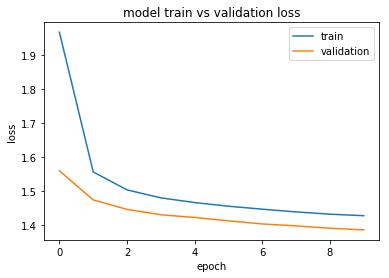

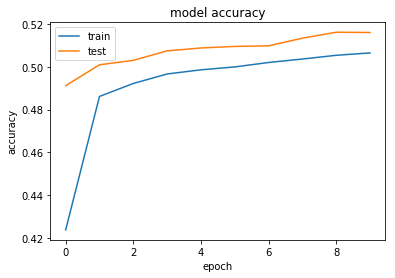

external 0 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 41s 90us/step - loss: 1.9566 - acc: 0.4166 - categorical_accuracy: 0.4166 - val_loss: 1.5548 - val_acc: 0.4896 - val_categorical_accuracy: 0.4896
Epoch 2/10
457127/457127 [==============================] - 37s 81us/step - loss: 1.5535 - acc: 0.4876 - categorical_accuracy: 0.4876 - val_loss: 1.4753 - val_acc: 0.4962 - val_categorical_accuracy: 0.4962
Epoch 3/10
457127/457127 [==============================] - 30s 65us/step - loss: 1.5005 - acc: 0.4938 - categorical_accuracy: 0.4938 - val_loss: 1.4444 - val_acc: 0.5005 - val_categorical_accuracy: 0.5005
Epoch 4/10
457127/457127 [==============================] - 31s 68us/step - loss: 1.4781 - acc: 0.4977 - categorical_accuracy: 0.4977 - val_loss: 1.4324 - val_acc: 0.5041 - val_categorical_accuracy: 0.5041
Epoch 5/10
457127/457127 [==============================] - 26s 57us/step - loss: 1.4650 - acc: 0.4998 -

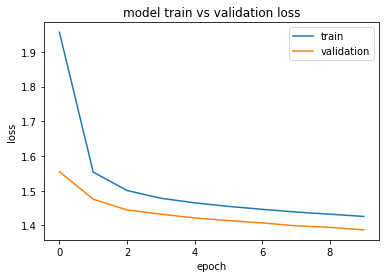

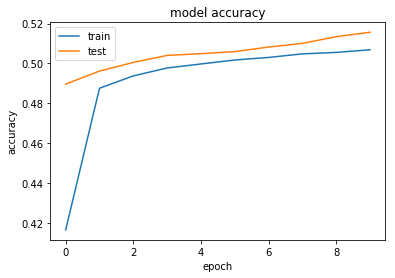

external 1 complete.
Train on 457127 samples, validate on 50792 samples
Epoch 1/10
457127/457127 [==============================] - 40s 88us/step - loss: 1.9610 - acc: 0.4224 - categorical_accuracy: 0.4224 - val_loss: 1.5450 - val_acc: 0.4931 - val_categorical_accuracy: 0.4931
Epoch 2/10
457127/457127 [==============================] - 23s 51us/step - loss: 1.5495 - acc: 0.4866 - categorical_accuracy: 0.4866 - val_loss: 1.4666 - val_acc: 0.4994 - val_categorical_accuracy: 0.4994
Epoch 3/10
457127/457127 [==============================] - 38s 83us/step - loss: 1.5007 - acc: 0.4936 - categorical_accuracy: 0.4936 - val_loss: 1.4451 - val_acc: 0.5044 - val_categorical_accuracy: 0.5044
Epoch 4/10
457127/457127 [==============================] - 33s 71us/step - loss: 1.4804 - acc: 0.4968 - categorical_accuracy: 0.4968 - val_loss: 1.4323 - val_acc: 0.5060 - val_categorical_accuracy: 0.5060
Epoch 5/10
457127/457127 [==============================] - 31s 68us/step - loss: 1.4674 - acc: 0.4989 -

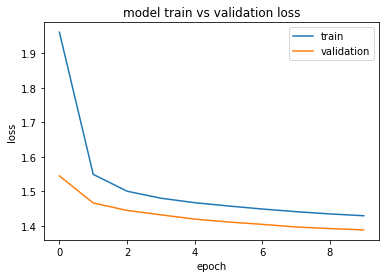

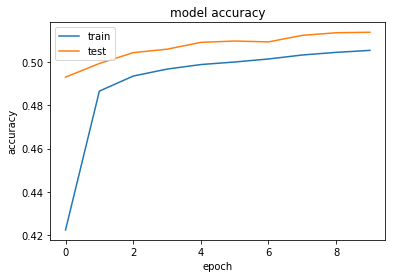

external 2 complete.


In [9]:
aggregations = ["source","destination","dyad","internal","external"]

for agg in aggregations:

    cicids_testing = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/cicids_"+agg+"_hour_testing.pickle","rb"))
    cicids_training = pickle.load(open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/data/cicids_"+agg+"_hour_training.pickle","rb"))

    X_test, Y_test, L_test = cicids_processing(cicids_testing["protobytes_sequence"].tolist(),
                             cicids_testing["label_sequence"].tolist(),
                             len(protobytes_fwd_dict)-1, seq_len, seq_skip, False)

#     pickle.dump(X_test, open("results/"+agg+"_protobytes_truth_X.pickle","wb"))
#     pickle.dump(Y_test, open("results/"+agg+"_protobytes_truth_Y.pickle","wb"))
    pickle.dump(L_test, open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/final_baseline/"+agg+"_protobytes_truth_L.pickle","wb"))

    for ii in range(num_models):

        X_train, Y_train, L_test = cicids_processing(cicids_training["protobytes_sequence"].tolist(),
                             cicids_training["label_sequence"].tolist(),
                             len(protobytes_fwd_dict)-1, seq_len, seq_skip, True)

        
        
        model_input = Input(shape=(seq_len, ))
        embedding_a = Embedding(len(protobytes_fwd_dict), 50, input_length=seq_len, mask_zero=True)(model_input)
        lstm_a = Bidirectional(GRU(25, return_sequences=True,implementation=2, reset_after=True, recurrent_activation='sigmoid'), merge_mode="concat")(embedding_a)
        dropout_a = Dropout(0.2)(lstm_a)
        lstm_b = Bidirectional(GRU(25, return_sequences=False, activation="relu", implementation=2, reset_after=True, recurrent_activation='sigmoid'), merge_mode="concat")(dropout_a)
        dropout_b = Dropout(0.2)(lstm_b)
        dense_layer = Dense(100, activation="linear")(dropout_b)
        dropout_c = Dropout(0.2)(dense_layer)
        model_output = Dense(len(protobytes_fwd_dict)-1, activation="softmax")(dropout_c)

        model = Model(inputs=model_input, outputs=model_output)
        model.compile(optimizer=TFOptimizer(tf.contrib.opt.LazyAdamOptimizer()), loss='categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])

        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, class_weight = 'auto')
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model train vs validation loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
        
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        
        label_input = Input(shape=(len(protobytes_fwd_dict)-1,))
        score_output = Dot(axes=(1,1))([model_output, label_input])
        pred_model = Model(inputs=[model_input,label_input], outputs=score_output)
        preds = pred_model.predict([X_test,Y_test], batch_size=batch_size)

        pickle.dump(preds,open("C:/Users/max/Documents/Master WIINFO/Masterarbeit/Code/Masterthesis/final_baseline/"+agg+"_"+str(ii)+"_protobytes_preds.pickle","wb"))

        print(agg + " " + str(ii) + " complete.")